# 1. Testing Code

In [1]:
## IMPORTS
import time, os, sys, healpy
import numpy as np
from classy import Class
sys.path.append('/mnt/home/ophilcox/PolyBin/')
import polybin as pb
from scipy.interpolate import InterpolatedUnivariateSpline

option = 1

In [2]:
# if len(sys.argv)!=3:
#     raise Exception("Need to specify fisher index and option")
# fish_index = int(sys.argv[1])
# option = int(sys.argv[2])

In [3]:
# HEALPix settings
Nside = 256
lmax = 3*Nside-1

# Whether to include a mask in practice
if option==1:
    flat_mask = False
elif option==2:
    flat_mask = True
else:
    raise Exception("Wrong option!")

In [4]:
pol=True
backend = 'libsharp'

outdir = '/mnt/ceph/users/ophilcox/polybin_testing/Cl/'

# Bin edges (could also be non-linearly spaced)
l_bins = np.arange(2,404,10)
Nl = len(l_bins)-1
print("binned lmax: %d, HEALPix lmax: %d"%(np.max(l_bins),lmax))
assert lmax>np.max(l_bins)

# Number of random iterations to create Fisher matrix
N_it = 100 # N ~ 50 is sufficient in practice, we'll use 10 for testing

# Number of simulations to use for testing
N_sim = 1000

# Number of CPUs to run code on
N_cpus = 40

# Whether to include the pixel window function
# This should be set to True, unless we generate maps at the same realization we analyze them!
include_pixel_window = False

# Whether to include bins only partially satisfying triangle conditions
include_partial_triangles = False

# Galactic Mask
# Using GAL040 mask with 2-degree apodization for testing
root = '/mnt/home/ophilcox/ceph/Oliver/planck/'
maskfile = 'HFI_Mask_GalPlane-apo2_2048_R2.00.fits'

cosmo = Class()

# Define ell arrays
l = np.arange(lmax+1)

# Run CLASS
cosmo.set({'output':'tCl,lCl,pCl,mPk','l_max_scalars':lmax+1,'lensing':'yes',
           'omega_b':0.022383,
           'non linear':'no',
           'omega_cdm':0.12011,
           'h':0.6732,
           'm_ncdm':0.06,
           'N_ncdm':1,
           'tau_reio':0.0543,
           'A_s':1e-10*np.exp(3.0448),
           'n_s':0.96605});
cosmo.compute()

# Compute dictionary of signal C_ell (note that we use all real fields by convention)
Cl_dict = cosmo.lensed_cl(lmax);
Cl_th = {}
if pol:
    r_TB = 0.5 # correlation of T and B (usually set to zero)
    r_EB = 0.5 # correlation of E and B (usually set to zer0)
    Cl_th = {}
    Cl_th['TT'] = Cl_dict['tt']*cosmo.T_cmb()**2
    Cl_th['TE'] = Cl_dict['te']*cosmo.T_cmb()**2
    Cl_th['TB'] = r_TB*np.sqrt(Cl_dict['tt']*Cl_dict['bb'])*cosmo.T_cmb()**2
    Cl_th['EE'] = Cl_dict['ee']*cosmo.T_cmb()**2
    Cl_th['EB'] = r_EB*np.sqrt(Cl_dict['ee']*Cl_dict['bb'])*cosmo.T_cmb()**2
    Cl_th['BB'] = Cl_dict['bb']*cosmo.T_cmb()**2
else:
    Cl_th['TT'] = Cl_dict['tt']*cosmo.T_cmb()**2
    
# Compute noise C_ell
DeltaT = 60./60.*np.pi/180.*1e-6 # in K-radians
DeltaP = 60./60.*np.pi/180.*1e-6*np.sqrt(2) 
thetaFWHM = 5./60.*np.pi/180. # in radians
NlT = DeltaT**2*np.exp(l*(l+1)*thetaFWHM**2/(8.*np.log(2)))*(l>=2)
NlP = DeltaP**2*np.exp(l*(l+1)*thetaFWHM**2/(8.*np.log(2)))*(l>=2)
Nl_th = {}
if pol:
    Nl_th['TT'] = NlT
    Nl_th['TE'] = Nl_th['TB'] = Nl_th['EB'] = 0.*NlT
    Nl_th['EE'] = Nl_th['BB'] = NlP
else:
    Nl_th['TT'] = NlT

if flat_mask:
    mask = 1.+0*healpy.ud_grade(healpy.read_map(root+maskfile,field=1),Nside)
else:
    mask = healpy.ud_grade(healpy.read_map(root+maskfile,field=1),Nside)
    
# Define fiducial beam and signal+noise
if not pol:
    beam = [1.+0.*l]
else:
    beam = [1.+0.*l, 1.+0.*l] # Temperature and polarization
Sl_fiducial = {}
for f in Cl_th.keys(): Sl_fiducial[f] = beam[0]**2*Cl_th[f]+Nl_th[f]+(Cl_th[f][2]+Nl_th[f][2])*(l<2) # avoiding zeros at l<2

# Define class, optionally including polarization
base = pb.PolyBin(Nside, Sl_fiducial, beam, include_pixel_window=include_pixel_window, pol=pol, backend=backend)

# Generate unmasked data with known C_l and factorized b
# Cl^XY are set to the fiducial spectrum unless otherwise specified
# No beam is included
print("Generating data")
raw_data = base.generate_data(seed=42, add_B=False)

# Mask the map
data = (raw_data*mask).reshape(len(raw_data),-1)

def applySinv(input_map, input_type='map', output_type='map'):
    """Apply the quasi-optimal weighting, S^{-1} to a map in map- or harmonic-space. 
    
    Here, we assume that the forward covariance is diagonal in ell (though not in fields), in particular C_l, and invert this.
    This is not quite the exact solution (as it incorrectly treats W(n) factors), but will be unbiased.
    
    Note that the code has two input and output options: "harmonic" or "map", to avoid unnecessary transforms.
    """
    assert input_type in ['harmonic','map'], "Valid input types are 'harmonic' and 'map' only!"
    assert output_type in ['harmonic','map'], "Valid output types are 'harmonic' and 'map' only!"
    
    # Transform to harmonic space, if necessary
    if input_type=='map': input_map_lm = base.to_lm(input_map)
    else: input_map_lm = input_map.copy()
    
    # Divide by covariance
    Cinv_data_lm = np.einsum('ijk,jk->ik',base.inv_Cl_lm_mat,input_map_lm,order='C')
        
    # Return to map-space, if necessary
    if output_type=='map': return base.to_map(Cinv_data_lm)
    else: return Cinv_data_lm

binned lmax: 402, HEALPix lmax: 767
## Caution: not accounting for pixel window function
Generating data


In [5]:
# Initialize power spectrum class

# Define fields to use
if pol:
    fields=['TT','TE','TB','EE','EB','BB'] # can use any subset of these!
else:
    fields = ['TT']

# NB: use mask = 1.+0.*mask if including mask projection in S^-1 (as in applySinv_planck)
pspec = pb.PSpec(base, mask, applySinv, l_bins, fields=fields)

# Zero cou/mnt/home/ophilcox/ceph/ (for diagnostics only)
base.n_SHTs_forward, base.n_SHTs_reverse = 0, 0

# Compute Fisher matrix, via multiprocessing
fish = pspec.compute_fisher(N_it, N_cpus=N_cpus, verb=False);

# Print some diagnostics
print("Fisher computation complete using %d forward and %d reverse SHTs per iteration"%(base.n_SHTs_forward//N_it, base.n_SHTs_reverse//N_it))
np.save(outdir+'Cl_fish%d.npy'%option,fish)

### Iterate over simulations and save

t1 = time.time()
base.n_SHTs_forward, base.n_SHTs_reverse = 0, 0

Cl_ideal = []
for ii in range(N_sim):
    print("Analyzing sim %d of %d"%(ii+1,N_sim))
    raw_sim = base.generate_data(ii,add_B=False)
    sim = mask*raw_sim
    Cl_ideal.append(pspec.Cl_ideal(sim))
    
print("Ideal sim computation complete, averaging %.2f time, %d / %d SHTs"%((time.time()-t1)/N_sim,base.n_SHTs_forward//N_sim,base.n_SHTs_reverse//N_sim))
    
np.save(outdir+'Cl_ideal%d.npy'%option,np.asarray(Cl_ideal))

t1 = time.time()
base.n_SHTs_forward, base.n_SHTs_reverse = 0, 0

Cl_unwindowed = []
for ii in range(N_sim):
    print("Analyzing sim %d of %d"%(ii+1,N_sim))
    raw_sim = base.generate_data(ii,add_B=False)
    sim = mask*raw_sim
    Cl_unwindowed.append(pspec.Cl_unwindowed(sim))
    
print("Unwindowed sim computation complete, averaging %.2f time, %d / %d SHTs"%((time.time()-t1)/N_sim,base.n_SHTs_forward//N_sim,base.n_SHTs_reverse//N_sim))

np.save(outdir+'Cl_unwindowed%d.npy'%option,np.asarray(Cl_unwindowed))

print("PROCESS COMPLETE!")

## Caution: Maximum l is greater than HEALPix-lmax/2; this might cause boundary effects.
Binning: 40 bins in [2, 402]
Fields: ['TT', 'TE', 'TB', 'EE', 'EB', 'BB']
Mask: spatially varying
Computing Fisher contribution from 100 Monte Carlo simulations on 40 threads


  0%|          | 0/100 [00:13<?, ?it/s]

KeyboardInterrupt



# 2. Analysis Code


### Imports

In [6]:
%pylab inline
import polybin as pb
import healpy
from scipy.interpolate import InterpolatedUnivariateSpline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/mnt/home/ophilcox/mpivenv2/lib/python3.9/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


### PolyBin setup

In [7]:
# Initialize power spectrum class

%pylab inline
import healpy
import polybin as pb
from classy import Class

pol=True
backend = 'libsharp'
flat_mask=False

# HEALPix settings
Nside = 256
lmax = 3*Nside-1

# Bin edges (could also be non-linearly spaced)
l_bins = np.arange(2,404,10)
Nl = len(l_bins)-1
print("binned lmax: %d, HEALPix lmax: %d"%(np.max(l_bins),lmax))
assert lmax>np.max(l_bins)

# Number of random iterations to create Fisher matrix
N_it = 2 # N ~ 50 is sufficient in practice, we'll use 10 for testing

# Number of simulations to use for testing
N_sim = 50

# Number of CPUs to run code on
N_cpus = 1

# Which code to use for harmonic transforms ["healpix" or "libsharp"] 
# libsharp is ~ 2x faster but needs pixell installed

# Whether to include the pixel window function
# This should be set to True, unless we generate maps at the same realization we analyze them!
include_pixel_window = False

# Whether to include bins only partially satisfying triangle conditions
include_partial_triangles = False

# Galactic Mask
# Using GAL040 mask with 2-degree apodization for testing
root = '/mnt/home/ophilcox/ceph/Oliver/planck/'
maskfile = 'HFI_Mask_GalPlane-apo2_2048_R2.00.fits'

cosmo = Class()

# Define ell arrays
l = np.arange(lmax+1)

# Run CLASS
cosmo.set({'output':'tCl,lCl,pCl,mPk','l_max_scalars':lmax+1,'lensing':'yes',
           'omega_b':0.022383,
           'non linear':'no',
           'omega_cdm':0.12011,
           'h':0.6732,
           'm_ncdm':0.06,
           'N_ncdm':1,
           'tau_reio':0.0543,
           'A_s':1e-10*np.exp(3.0448),
           'n_s':0.96605});
cosmo.compute()

# Compute dictionary of signal C_ell (note that we use all real fields by convention)
Cl_dict = cosmo.lensed_cl(lmax);
Cl_th = {}
if pol:
    r_TB = 0.5 # correlation of T and B (usually set to zero)
    r_EB = 0.5 # correlation of E and B (usually set to zer0)
    Cl_th = {}
    Cl_th['TT'] = Cl_dict['tt']*cosmo.T_cmb()**2
    Cl_th['TE'] = Cl_dict['te']*cosmo.T_cmb()**2
    Cl_th['TB'] = r_TB*np.sqrt(Cl_dict['tt']*Cl_dict['bb'])*cosmo.T_cmb()**2
    Cl_th['EE'] = Cl_dict['ee']*cosmo.T_cmb()**2
    Cl_th['EB'] = r_EB*np.sqrt(Cl_dict['ee']*Cl_dict['bb'])*cosmo.T_cmb()**2
    Cl_th['BB'] = Cl_dict['bb']*cosmo.T_cmb()**2
else:
    Cl_th['TT'] = Cl_dict['tt']*cosmo.T_cmb()**2
    
# Compute noise C_ell
DeltaT = 60./60.*np.pi/180.*1e-6 # in K-radians
DeltaP = 60./60.*np.pi/180.*1e-6*np.sqrt(2) 
thetaFWHM = 5./60.*np.pi/180. # in radians
NlT = DeltaT**2*np.exp(l*(l+1)*thetaFWHM**2/(8.*np.log(2)))*(l>=2)
NlP = DeltaP**2*np.exp(l*(l+1)*thetaFWHM**2/(8.*np.log(2)))*(l>=2)
Nl_th = {}
if pol:
    Nl_th['TT'] = NlT
    Nl_th['TE'] = Nl_th['TB'] = Nl_th['EB'] = 0.*NlT
    Nl_th['EE'] = Nl_th['BB'] = NlP
else:
    Nl_th['TT'] = NlT
    
if flat_mask:
    mask = 1.+0*healpy.ud_grade(healpy.read_map(root+maskfile,field=1),Nside)
else:
    mask = healpy.ud_grade(healpy.read_map(root+maskfile,field=1),Nside)
    
# Define fiducial beam and signal+noise
if not pol:
    beam = [1.+0.*l]
else:
    beam = [1.+0.*l, 1.+0.*l] # Temperature and polarization
Sl_fiducial = {}
for f in Cl_th.keys(): Sl_fiducial[f] = beam[0]**2*Cl_th[f]+Nl_th[f]+(Cl_th[f][2]+Nl_th[f][2])*(l<2) # avoiding zeros at l<2

# Define class, optionally including polarization
base = pb.PolyBin(Nside, Sl_fiducial, beam, include_pixel_window=include_pixel_window, pol=pol, backend=backend)

# Generate unmasked data with known C_l and factorized b
# Cl^XY are set to the fiducial spectrum unless otherwise specified
# No beam is included
raw_data = base.generate_data(seed=42, add_B=False)

# Mask the map
data = (raw_data*mask).reshape(len(raw_data),-1)

def applySinv(input_map, input_type='map', output_type='map'):
    """Apply the quasi-optimal weighting, S^{-1} to a map in map- or harmonic-space. 
    
    Here, we assume that the forward covariance is diagonal in ell (though not in fields), in particular C_l, and invert this.
    This is not quite the exact solution (as it incorrectly treats W(n) factors), but will be unbiased.
    
    Note that the code has two input and output options: "harmonic" or "map", to avoid unnecessary transforms.
    """
    assert input_type in ['harmonic','map'], "Valid input types are 'harmonic' and 'map' only!"
    assert output_type in ['harmonic','map'], "Valid output types are 'harmonic' and 'map' only!"
    
    # Transform to harmonic space, if necessary
    if input_type=='map': input_map_lm = base.to_lm(input_map)
    else: input_map_lm = input_map.copy()
    
    # Divide by covariance
    Cinv_data_lm = np.einsum('ijk,jk->ik',base.inv_Cl_lm_mat,input_map_lm,order='C')
        
    # Return to map-space, if necessary
    if output_type=='map': return base.to_map(Cinv_data_lm)
    else: return Cinv_data_lm

# Define fields to use
if pol:
    fields=['TT','TE','TB','EE','EB','BB'] # can use any subset of these!
else:
    fields = ['TT']

# NB: use mask = 1.+0.*mask if including mask projection in S^-1 (as in applySinv_planck)
pspec = pb.PSpec(base, mask, applySinv, l_bins, fields=fields)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
binned lmax: 402, HEALPix lmax: 767
## Caution: not accounting for pixel window function
## Caution: Maximum l is greater than HEALPix-lmax/2; this might cause boundary effects.
Binning: 40 bins in [2, 402]
Fields: ['TT', 'TE', 'TB', 'EE', 'EB', 'BB']
Mask: spatially varying


### Compute ideal P Fisher

In [8]:
outdir = '/mnt/home/ophilcox/ceph/polybin_testing/Cl/'

option = 1

### Load Fisher
fish = []
for i in range(10):
    fish.append(np.load(outdir+'Cl_fish%d_%d.npy'%(option,i)))
fish = np.concatenate(fish).mean(axis=0)
inv_fish = np.linalg.inv(fish)

fields=['TT','TE','TB','EE','EB','BB']

pspec.compute_fisher_ideal()

### Load ideal
ideal = []
for i in range(10):
    ideal.append(np.load(outdir+'Cl_ideal%d_%d.npy'%(option,i)))
ideal = np.concatenate(ideal)
ideal = np.asarray([pspec.inv_fish_ideal@ideal1.reshape(-1) for ideal1 in ideal])
ideal_cov = np.cov(ideal.T)

In [9]:
### Load unwindowed
unwindowed = []
for i in range(10):
    unwindowed.append(np.load(outdir+'Cl_unwindowed%d_%d.npy'%(option,i)))
unwindowed = np.concatenate(unwindowed)
unwindowed = np.asarray([inv_fish@unwindowed1.ravel() for unwindowed1 in unwindowed])
unwindowed_cov = np.cov(unwindowed.reshape(1000,-1).T)

Cl_ideal_all, Cl_unwindowed_all = {},{}
index = 0
for field in fields:
    Cl_ideal_all[field] = ideal[:,index:index+len(l_bins)-1]
    Cl_unwindowed_all[field] = unwindowed[:,index:index+len(l_bins)-1]
    index += len(l_bins)-1

In [10]:
# plt.plot((unwindowed10.mean(axis=0)-unwindowed100.mean(axis=0))/unwindowed100.std(axis=0))

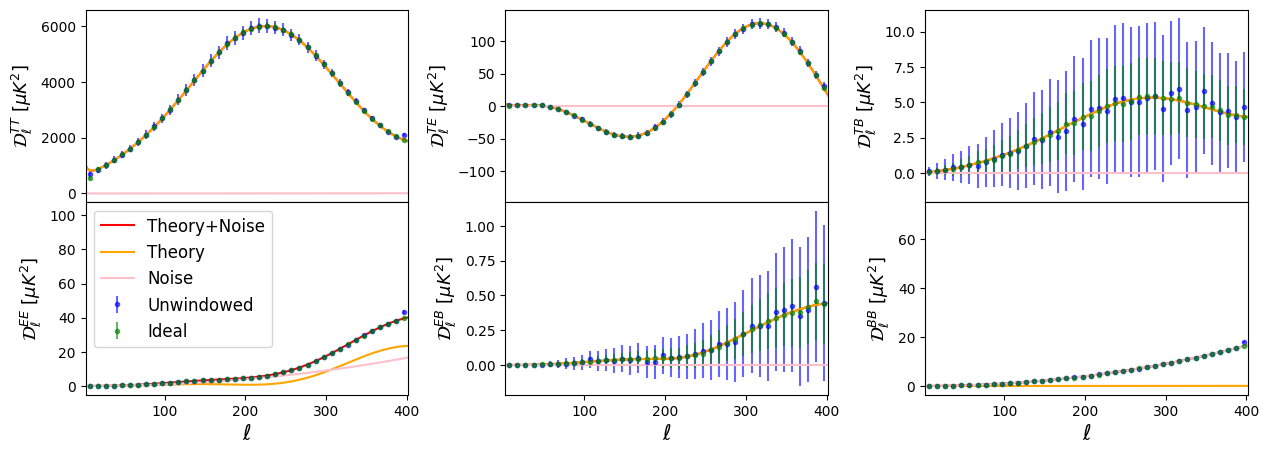

In [13]:
l_av = 0.5*(l_bins[1:]+l_bins[:-1])
pref_av = l_av*(l_av+1.)/(2.*np.pi)*1e12
pref = l*(l+1)/(2.*np.pi)*1e12

fig, ax = plt.subplots(2,3,figsize=(15,5),sharex=True)
plt.subplots_adjust(wspace=0.3,hspace=0.0)
indices = [(0,0),(0,1),(0,2),(1,0),(1,1),(1,2)]

for i,field in enumerate(pspec.fields):
    
    # Fisher error
    fish_err = np.sqrt(np.diag(inv_fish)[i*pspec.Nl:(i+1)*pspec.Nl])
    fish_err_ideal = np.sqrt(np.diag(pspec.inv_fish_ideal)[i*pspec.Nl:(i+1)*pspec.Nl])
    if option==1: fish_err_ideal*np.sqrt(np.mean(mask**4.)/np.mean(mask**2)**2)
    
    # Plot spectra
    ax[indices[i]].errorbar(l_av,pref_av*np.asarray(Cl_unwindowed_all[field]).mean(axis=0),yerr=pref_av*fish_err,marker='.',ls='',label='Unwindowed',c='b',alpha=0.6)
    ax[indices[i]].errorbar(l_av,pref_av*np.asarray(Cl_ideal_all[field]).mean(axis=0),yerr=pref_av*fish_err_ideal,marker='.',ls='',label='Ideal',c='g',alpha=0.6)
    ax[indices[i]].plot(l,pref*(Cl_th[field]+Nl_th[field]/(1e-12+beam[0]**2)),label='Theory+Noise',c='r')
    ax[indices[i]].plot(l,pref*Cl_th[field],label='Theory',c='orange')
    ax[indices[i]].plot(l,pref*Nl_th[field]/(1e-12+beam[0]**2),label='Noise',c='pink')
    # #plt.errorbar(l,pref*np.mean(Cl_raw_all[field],axis=0),yerr=pref*np.std(Cl_raw_all[field],axis=0),label='Raw Data',alpha=0.3)
    ax[indices[i]].set_xlim([min(l_bins),max(l_bins)])
    if i>2: ax[indices[i]].set_xlabel(r'$\ell$',fontsize=15)
    ax[indices[i]].set_ylabel(r'$\mathcal{D}^{%s}_\ell\,\,[\mu K^2]$'%field,fontsize=13)
    if i==3: ax[indices[i]].legend(fontsize=12)
    #ax[indices[i]].set_ylim([1.5*min(pref_av*np.asarray(Cl_ideal_all[field]).mean(axis=0)),1.5*max(pref_av*np.asarray(Cl_ideal_all[field]).mean(axis=0))])
fig.savefig('Cl_validation.pdf',bbox_inches='tight')

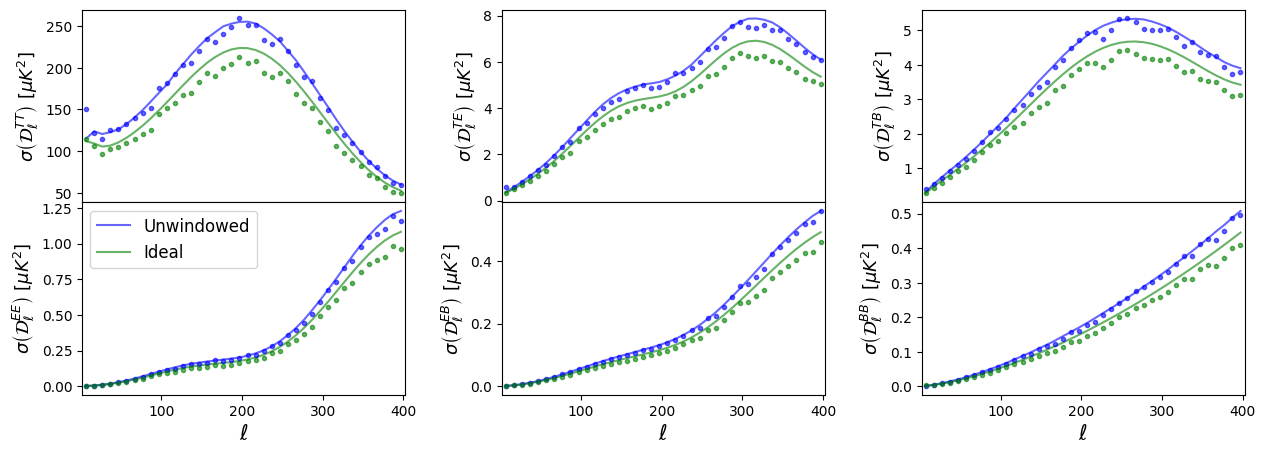

In [14]:
fig, ax = plt.subplots(2,3,figsize=(15,5),sharex=True)
plt.subplots_adjust(wspace=0.3,hspace=0.0)

for i,field in enumerate(pspec.fields):
    
    # Fisher error
    fish_err = np.sqrt(np.diag(inv_fish)[i*pspec.Nl:(i+1)*pspec.Nl])
    fish_err_ideal = np.sqrt(np.diag(pspec.inv_fish_ideal)[i*pspec.Nl:(i+1)*pspec.Nl])*np.sqrt(np.mean(mask**4.)/np.mean(mask**2)**2)
    if option==1: fish_err_ideal*np.sqrt(np.mean(mask**4.)/np.mean(mask**2)**2)
    
    # Plot spectra
    ax[indices[i]].errorbar(l_av,pref_av*fish_err,ls='-',label='Unwindowed',c='b',alpha=0.6)
    ax[indices[i]].errorbar(l_av,pref_av*fish_err_ideal,ls='-',label='Ideal',c='g',alpha=0.6)
    
    ax[indices[i]].errorbar(l_av,pref_av*np.asarray(Cl_unwindowed_all[field]).std(axis=0),marker='.',ls='',c='b',alpha=0.6)
    ax[indices[i]].errorbar(l_av,pref_av*np.asarray(Cl_ideal_all[field]).std(axis=0),marker='.',ls='',c='g',alpha=0.6)
    
    # #plt.errorbar(l,pref*np.mean(Cl_raw_all[field],axis=0),yerr=pref*np.std(Cl_raw_all[field],axis=0),label='Raw Data',alpha=0.3)
    ax[indices[i]].set_xlim([min(l_bins),max(l_bins)])
    if i>2: ax[indices[i]].set_xlabel(r'$\ell$',fontsize=15)
    ax[indices[i]].set_ylabel(r'$\sigma\left(\mathcal{D}^{%s}_\ell\right)\,\,[\mu K^2]$'%field,fontsize=13)
    if i==3: ax[indices[i]].legend(fontsize=12)
    # #plt.ylim([1.5*min(pref_av*Cl_ideal[field]),1.5*max(pref_av*Cl_ideal[field])])
fig.savefig('Cl_validation_err.pdf',bbox_inches='tight')

In [42]:
# Plot Fisher matrices (real and ideal)

def plot_correlation(matrix,matrix2=[],v=0.5,title='',outfile=[],labs=[]):
    # Define correlation
    corr_matrix = matrix/np.sqrt(np.outer(np.diag(matrix),np.diag(matrix)))
    
    if len(matrix2)>0:
        corr_matrix2 = matrix2/np.sqrt(np.outer(np.diag(matrix2),np.diag(matrix2)))
        indices = np.triu_indices(len(corr_matrix))
        corr_matrix[indices] = corr_matrix2[indices]

    # Plot matrix
    fig,ax = plt.subplots()
    pp = ax.imshow(corr_matrix-np.eye(len(corr_matrix)),cmap=cm.RdBu_r,vmax=v,vmin=-v)
    ax.set_title(title)
    plt.colorbar(pp,fraction=0.04762, pad=0.0);
    
    for i in range(len(pspec.fields)):
        plt.hlines(i*pspec.Nl-0.5,0,len(pspec.fields)*pspec.Nl,linestyles=':',color='k',alpha=0.1)
        plt.vlines(i*pspec.Nl-0.5,0,len(pspec.fields)*pspec.Nl,linestyles=':',color='k',alpha=0.1)
    plt.xlim(-0.5,len(matrix)-0.5)
    plt.ylim(len(matrix)-0.5,-0.5)
    
    inds = np.asarray([pspec.Nl*(i+0.5) for i in range(len(fields))])
    plt.gca().set_xticks(inds)
    ax.set_xticklabels(list(Cl_ideal_all.keys()), rotation=0, family='monospace')
    ax.set_yticks(inds)
    ax.set_yticklabels(list(Cl_ideal_all.keys()), family='monospace')
    
    if len(labs)>0:
        plt.text(len(matrix)//16,len(matrix)*15//16,labs[0],c='purple')
        plt.text(len(matrix)*4//7,len(matrix)//16,labs[1],c='purple')    
    
    if len(outfile)>0:
        plt.savefig(outfile, bbox_inches='tight')

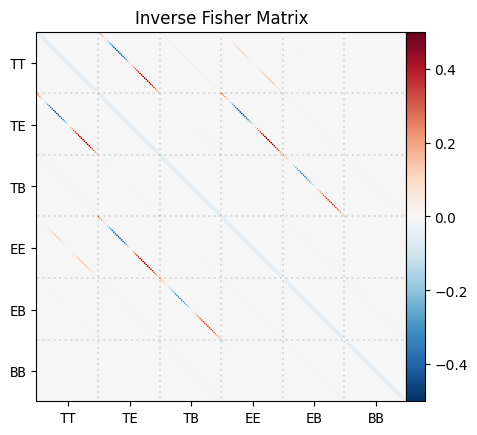

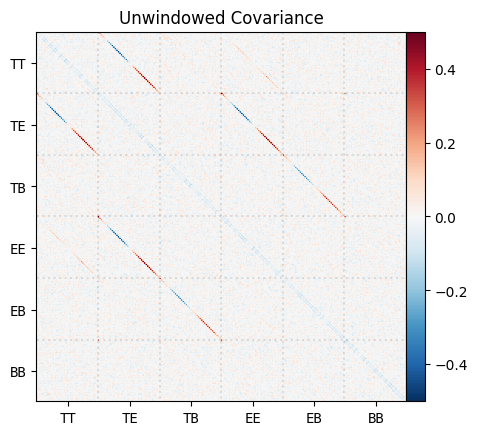

In [32]:
plot_correlation(inv_fish,title="Inverse Fisher Matrix",v=0.5,outfile='Cl_cov_true.pdf')
plot_correlation(unwindowed_cov,title="Unwindowed Covariance",v=0.5,outfile='Cl_cov_fisher.pdf')

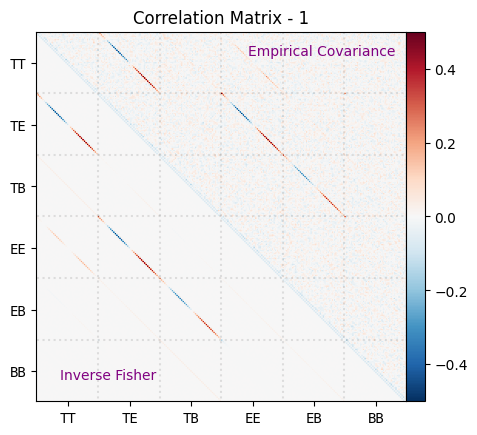

In [43]:
plot_correlation(inv_fish, unwindowed_cov, title='Correlation Matrix - 1',v=0.5,labs=['Inverse Fisher','Empirical Covariance'],outfile='Cl_cov_comparison.pdf')

# OLD

### Options

In [3]:
# HEALPix settings
Nside = 256
lmax = 3*Nside-1

# Binning parameters
dl = 4 # width
Nl = 100 # number
min_l = 2 # minimum
print("binned lmax: %d,"%(min_l+dl*Nl),"HEALPix lmax: %d"%lmax)

# Number of random iterations to create Fisher matrix
N_it = 100

# Number of simulations to use for testing
N_sim = 1000

# Whether to include bins only partially satisfying triangle conditions
include_partial_triangles = False

# whether to add a separable reduced bispectrum to the input maps
include_synthetic_b = False
b_input_fac = lambda l1: np.exp(-(l1-2)/40.)*2e-6

# Galactic Mask
# Using GAL040 mask with 2-degree apodization for testing
root = '/projects/QUIJOTE/Oliver/planck/'
maskfile = 'HFI_Mask_GalPlane-apo2_2048_R2.00.fits'

# Whether to include a mask in practice
use_mask = True

binned lmax: 402, HEALPix lmax: 767


### Fiducial Power and Noise Spectrum

In [4]:
from classy import Class
cosmo = Class()

# Define ell arrays
l = np.arange(lmax+1)

# Run CLASS
cosmo.set({'output':'tCl,lCl,mPk','l_max_scalars':lmax+1,'lensing':'yes',
           'omega_b':0.022383,
           'non linear':'no',
           'omega_cdm':0.12011,
           'h':0.6732,
           'm_ncdm':0.06,
           'N_ncdm':1,
           'tau_reio':0.0543,
           'A_s':1e-10*np.exp(3.0448),
           'n_s':0.96605});
cosmo.compute()

# Compute signal C_ell
Cl_dict = cosmo.lensed_cl(lmax);
Cl_th = Cl_dict['tt']*cosmo.T_cmb()**2

# Compute noise C_ell
DeltaT = 60./60.*np.pi/180.*1e-6 # in K-radians
thetaFWHM = 5./60.*np.pi/180. # in radians
Nl_th = DeltaT**2*np.exp(l*(l+1)*thetaFWHM**2/(8.*np.log(2)))*(l>2)

### Load mask

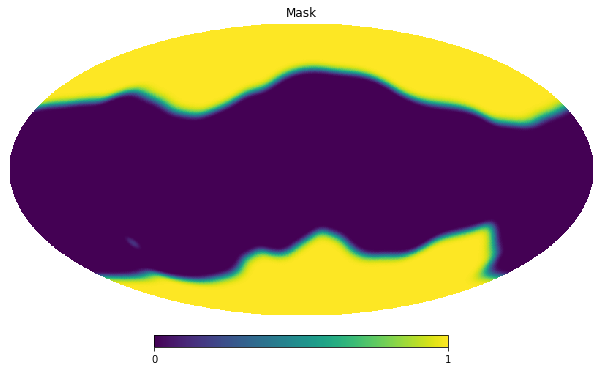

In [5]:
mask = healpy.ud_grade(healpy.read_map(root+maskfile,field=1),Nside)

if not use_mask:
    mask = 1.+0.*mask

healpy.mollview(mask,title='Mask')

### Initialize PolyBin class

In [6]:
# Load class with fiducial Cl and Nside
base = pb.PolyBin(Nside, Cl_th+Nl_th)

### Generate Synthetic Data with known $C_\ell$, $b_{\ell_1\ell_2\ell_3}$

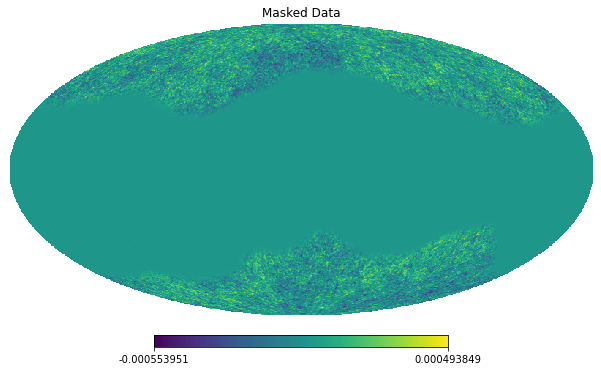

In [7]:
# Generate unmasked data with known C_l and factorized b
# Cl is set to the fiducial spectrum unless otherwise specified
# No beam is included
raw_data = base.generate_data(seed=42, add_B=include_synthetic_b, b_input=b_input_fac)

# Mask the map
data = raw_data*mask

# Plot the data
healpy.mollview(data,title='Masked Data')

### Define weighting function (user-set)
- A simple option would be ```applySinv=base.applyUinv```, which matches the code below.
- The idealized estimators just use a $C_{\rm fid}^{-1}$ weighting (which should include noise).

In [8]:
def applySinv(input_map):
    """Apply the optimal weighting to a map. 
    
    Here, we assume that the forward covariance is diagonal, in particular C_l, and invert this.
    This is not quite the exact solution (as it incorrectly treats W(n) factors), but should be unbiased."""
    
    # Transform to harmonic space
    input_map_lm = base.to_lm(input_map)
    # Divide by covariance and return to map-space
    Cinv_map = base.to_map(base.safe_divide(input_map_lm,base.Cl_lm))
    
    return Cinv_map

### Compute Unbinned Power Spectra

(2.0, 767.0)

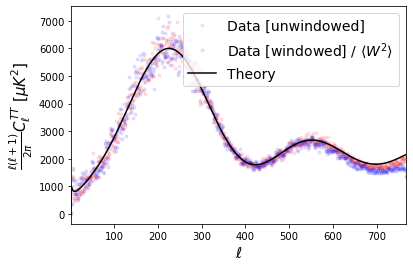

In [9]:
# Compute power spectra
av_sq_mask = np.mean(mask**2)
Cl_raw_healpy = healpy.alm2cl(base.to_lm(raw_data))
Cl_healpy = healpy.alm2cl(base.to_lm(data))/av_sq_mask

# Plot results
pref = l*(l+1)/(2.*np.pi)*1e12
plt.plot(l,pref*Cl_raw_healpy,label='Data [unwindowed]',ls='',marker='.',alpha=0.1,c='r')
plt.plot(l,pref*Cl_healpy,label=r'Data [windowed] / $\langle W^2\rangle$',ls='',marker='.',alpha=0.1,c='b')
plt.plot(l,pref*base.Cl,label='Theory',c='k')
plt.xlabel(r'$\ell$',fontsize=15)
plt.legend(fontsize=14)
plt.ylabel(r'$\frac{\ell(\ell+1)}{2\pi}C_\ell^{TT}\,\,[\mu K^2]$',fontsize=15)
plt.xlim([2,lmax])

In [10]:
importlib.reload(pb)
base = pb.PolyBin(Nside,Cl_th+Nl_th)

### Power Spectrum Estimation

Let's compute the binned power spectrum of the map, using both the idealized and optimal estimators. The unwindowed estimator requires a Fisher matrix which we can compute via multiprocessing. Note that the Fisher matrix is independent of the data, thus only needs to be computed once per mask / binning choice.

### Load Fisher matrices

In [24]:
N_it = 100

In [25]:
### Load external Fisher matrices
fishs = []
for option in [1,2]:
    fish = 0.
    ct = 0
    for i in range(N_it):
        try:
            fish += np.load('/projects/QUIJOTE/Oliver/polybin_testing/pfish%d_%d.npy'%(option,i))
            ct += 1
        except IOError:
            pass
    fish /= ct
    print("Using %d simulations"%ct)
    fishs.append(fish)

Using 100 simulations
Using 100 simulations


### Load spectra

In [13]:
pspec_win = pb.PSpec(base, mask, applySinv, min_l, dl, Nl)
pspec_nowin = pb.PSpec(base, 1.+0.*mask, applySinv, min_l, dl, Nl)

# Compute unwindowed power spectrum, passing the Fisher matrix
Cl_ideal_nowin = pspec_nowin.Cl_ideal(raw_data)
Cl_ideal_win = pspec_win.Cl_ideal(data)

Binning: 100 bins in [2, 402]
Binning: 100 bins in [2, 402]
Computing ideal Fisher matrix
Computing ideal Fisher matrix


In [14]:
Cl_opts = []
Cl_ideals = []

fish_ideals = [pspec_nowin.fish_ideal,pspec_win.fish_ideal]

for o,option in enumerate([1,2]):
    
    inv_fish = np.linalg.inv(fishs[o])
    inv_fish_ideal = np.linalg.inv(fish_ideals[o])

    Cl_opt, Cl_ideal = [],[]
    ct = 0
    for i in range(N_sim):
        try:
            Cl_opt.append(inv_fish@np.load('/projects/QUIJOTE/Oliver/polybin_testing/pnum%d-opt%d.npy'%(option,i)))
            Cl_ideal.append(inv_fish_ideal@np.load('/projects/QUIJOTE/Oliver/polybin_testing/pnum%d-ideal%d.npy'%(option,i)))
            ct += 1
        except IOError:
            pass
    print("Using %d simulations"%ct)
                            
    Cl_opts.append(Cl_opt)
    Cl_ideals.append(Cl_ideal)

Using 1000 simulations
Using 1000 simulations


In [18]:
Cl_nums = (fishs[1]@np.asarray(Cl_opts[1]).T).T

In [22]:
inv_fish = np.linalg.inv(fishs[1])
Cl_o10 = (inv_fish@Cl_nums.T).T

### fraction of statistical error?

In [23]:
np.mean(np.abs(np.mean(Cl_o10-Cl_o100,axis=0)/np.std(Cl_o100,axis=0)))

0.23297525513416273

### Load numerators

In [15]:
# # Compute Fisher matrix on 4 CPUs
# fish = pspec.compute_fisher(N_it, N_cpus=4);

# Compute unwindowed power spectrum
Cl_opt_1 = pspec_nowin.Cl_unwindowed(raw_data, fish=fishs[0])
Cl_opt_2 = pspec_win.Cl_unwindowed(data, fish=fishs[1])

Let's also compute the idealized binned power spectrum and plot the results, noting that the final bin or two will be biased since we ignore the correlations with the higher bins. These would be excluded in any real analysis.

We also plot the Fisher matrix, which shows how correlated individual bins are as a result of the window. Note that the covariance matrix is the inverse of the Fisher matrix. 

### Plots

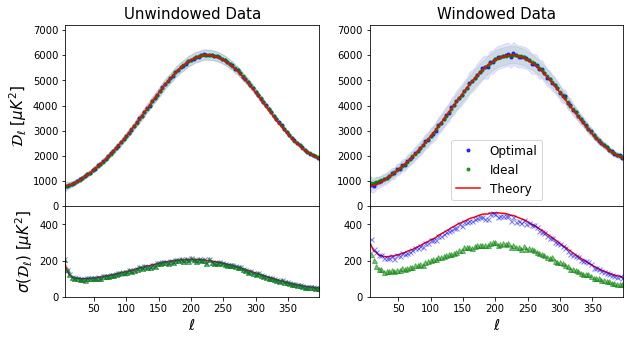

In [26]:
l_av = np.asarray([min_l+dl/2+dl*bin1 for bin1 in range(Nl)])
pref_av = l_av*(l_av+1.)/(2.*np.pi)*1e12

fig, ax = plt.subplots(2,2,figsize=(10,5),sharex=True,sharey=False,gridspec_kw={'height_ratios': [2,1]})
    
for i in [0,1]:
    fig.subplots_adjust(hspace=0)

    inv_fish_opt = np.linalg.inv(fishs[i])
    inv_fish_ideal = np.linalg.inv(fish_ideals[i])
    
    fish_err = np.sqrt(np.diag(inv_fish_opt))
    if i==0:
        fish_err_ideal = np.sqrt(np.diag(inv_fish_ideal))
    else:
        fish_err_ideal = np.sqrt(np.diag(inv_fish_ideal))*np.sqrt(np.mean(mask**4)/np.mean(mask**2)**2)

    # Spectra
    ax[0,i].plot(l_av,pref_av*np.asarray(Cl_opts[i]).mean(axis=0),marker='.',ls='',
                   label='Optimal',c='b',alpha=0.8)
    ax[0,i].fill_between(l_av,pref_av*np.asarray(Cl_opts[i]).mean(axis=0)-pref_av*fish_err,
                              pref_av*np.asarray(Cl_opts[i]).mean(axis=0)+pref_av*fish_err,
                         color='b',alpha=0.1)
    
    ax[0,i].plot(l_av,pref_av*np.asarray(Cl_ideals[i]).mean(axis=0),marker='.',ls='',
                   label='Ideal',c='g',alpha=0.8)
    ax[0,i].fill_between(l_av,pref_av*np.asarray(Cl_ideals[i]).mean(axis=0)-pref_av*fish_err_ideal,
                         pref_av*np.asarray(Cl_ideals[i]).mean(axis=0)+pref_av*fish_err_ideal,
                         color='g',alpha=0.1)
    
    ax[0,i].plot(l,pref*Cl_th,label='Theory',c='r')

    # Errors
    ax[1,i].plot(l_av,pref_av*fish_err,label='Expected error (unwindowed)',c='r',ls='-')
    ax[1,i].plot(l_av,pref_av*np.asarray(Cl_opts[i]).std(axis=0),label='Unwindowed Error',
               c='b',marker='x',ls='',alpha=0.5,ms=5)
    ax[1,i].plot(l_av,pref_av*np.asarray(Cl_ideals[i]).std(axis=0),label='Idealized Error',
               c='g',marker='^',ls='',alpha=0.5,ms=5)

    # Axes
    if i==0:
        ax[0,i].set_title('Unwindowed Data',fontsize=15)
    else:
        ax[0,i].set_title('Windowed Data',fontsize=15)
    ax[1,i].set_xlabel(r'$\ell$',fontsize=15)
    if i==0:
        ax[0,i].set_ylabel(r'$\mathcal{D}_\ell\,\,[\mu K^2]$',fontsize=15)
        ax[1,i].set_ylabel(r'$\sigma(\mathcal{D}_\ell)\,\,[\mu K^2]$',fontsize=15);
    if i==1:
        ax[0,i].legend(fontsize=12)
    ax[0,i].set_ylim([0,7200])
    ax[1,i].set_ylim([0,500])
    ax[0,i].set_xlim([min_l+dl,min_l+Nl*dl-dl])
fig.savefig('testing/Cl_plot.pdf',bbox_inches='tight')

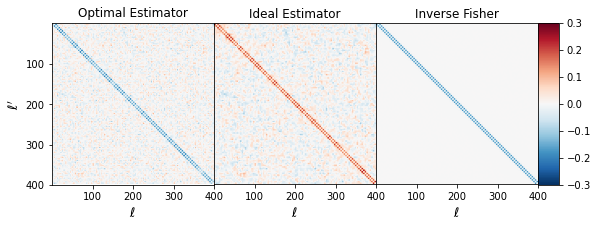

In [34]:
# Plot correlation matrices
#fchol = np.linalg.cholesky(fishs[1]).T
cov_ideal = np.cov(np.asarray(Cl_ideals[1]).T)
corr_ideal = cov_ideal/np.sqrt(np.outer(np.diag(cov_ideal),np.diag(cov_ideal)))
#cov_unwindowed = np.cov(fchol@np.asarray(Cl_opts[1]).T)
cov_unwindowed = np.cov(np.asarray(Cl_opts[1]).T)
corr_unwindowed = cov_unwindowed/np.sqrt(np.outer(np.diag(cov_unwindowed),np.diag(cov_unwindowed)))
cov_theory = np.linalg.inv(fishs[1])
corr_theory = cov_theory/np.sqrt(np.outer(np.diag(cov_theory),np.diag(cov_theory)))

fig,ax = plt.subplots(1,3,figsize=(10,30))
fig.subplots_adjust(wspace=0)
v=0.3
im=ax[0].imshow(corr_unwindowed-np.eye(len(corr_unwindowed)),cmap=cm.RdBu_r,vmax=v,vmin=-v)
im=ax[1].imshow(corr_ideal-np.eye(len(corr_ideal)),cmap=cm.RdBu_r,vmax=v,vmin=-v)
ax[2].imshow(corr_theory-np.eye(len(corr_theory)),cmap=cm.RdBu_r,vmax=v,vmin=-v)
ax[0].set_title("Optimal Estimator")
ax[1].set_title("Ideal Estimator")
ax[2].set_title("Inverse Fisher")
for i in range(3):
    ax[i].set_xticks([25,50,75,100])
    ax[i].set_xticklabels([100,200,300,400])
ax[0].set_yticks([25,50,75,100])
ax[0].set_yticklabels([100,200,300,400])
for i in range(1,3):
    ax[i].set_yticks([])
    ax[i].set_yticklabels([])
fig.subplots_adjust(right=0.8)
for i in range(3):
    ax[i].set_xlabel(r'$\ell$',fontsize=13)
ax[0].set_ylabel(r"$\ell'$",fontsize=13)
cbar_ax = fig.add_axes([0.80, 0.465, 0.03, 0.075])
fig.colorbar(im, cax=cbar_ax)
fig.savefig('testing/Cl_cov.pdf',bbox_inches='tight')

# note we don't expect perfect optimality if $S \neq \tilde{C}$!

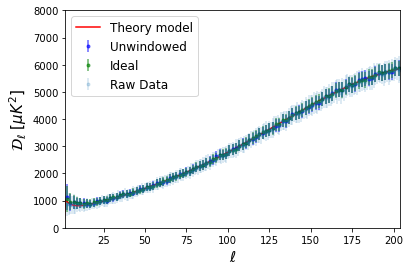

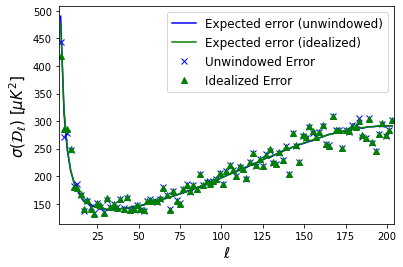

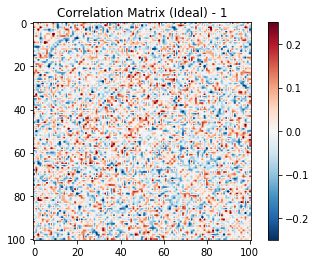

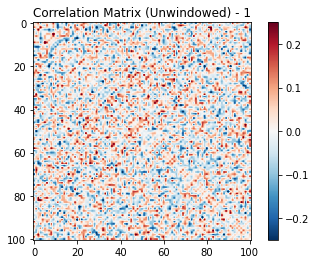

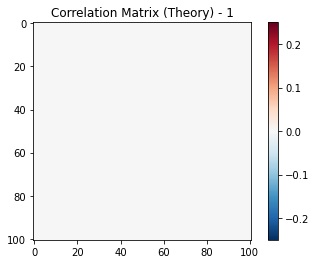

In [16]:
l_av = np.asarray([min_l+dl/2+dl*bin1 for bin1 in range(Nl)])
pref_av = l_av*(l_av+1.)/(2.*np.pi)*1e12

fish_err = np.sqrt(np.diag(pspec.inv_fish))
fish_err_ideal = np.sqrt(np.diag(pspec.inv_fish_ideal))*np.sqrt(np.mean(mask**4)/np.mean(mask**2)**2)
plt.errorbar(l_av,pref_av*np.asarray(Cl_unwindowed_all).mean(axis=0),yerr=pref_av*fish_err,marker='.',ls='',label='Unwindowed',c='b',alpha=0.6)
plt.errorbar(l_av,pref_av*np.asarray(Cl_ideal_all).mean(axis=0),yerr=pref_av*fish_err_ideal,marker='.',ls='',label='Ideal',c='g',alpha=0.6)
plt.plot(l,pref*Cl_th,label='Theory model',c='r')
plt.errorbar(l,pref*np.asarray(Cl_raw_all).mean(axis=0),yerr=pref*np.asarray(Cl_raw_all).std(axis=0),
             ls='',marker='.',label='Raw Data',alpha=0.2)
plt.xlim([0,lmax])
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$\mathcal{D}_\ell\,\,[\mu K^2]$',fontsize=15)
plt.legend(fontsize=12)
plt.ylim([0,8000])
plt.xlim([min_l,min_l+Nl*dl])

plt.figure()
plt.plot(l_av,pref_av*fish_err,label='Expected error (unwindowed)',c='b')
plt.plot(l_av,pref_av*fish_err_ideal,label='Expected error (idealized)',c='g')
plt.plot(l_av,pref_av*np.asarray(Cl_unwindowed_all).std(axis=0),label='Unwindowed Error',c='b',marker='x',ls='')
plt.plot(l_av,pref_av*np.asarray(Cl_ideal_all).std(axis=0),label='Idealized Error',c='g',marker='^',ls='')
plt.xlabel(r'$\ell$',fontsize=15)
plt.legend(fontsize=12)
plt.ylabel(r'$\sigma(\mathcal{D}_\ell)\,\,[\mu K^2]$',fontsize=15);
plt.xlim([min_l,min_l+Nl*dl]);

# Plot correlation matrices
cov_ideal = np.cov(np.asarray(Cl_ideal_all).T)
corr_ideal = cov_ideal/np.sqrt(np.outer(np.diag(cov_ideal),np.diag(cov_ideal)))
cov_unwindowed = np.cov(np.asarray(Cl_unwindowed_all).T)
corr_unwindowed = cov_unwindowed/np.sqrt(np.outer(np.diag(cov_unwindowed),np.diag(cov_unwindowed)))
cov_theory = np.linalg.inv(pspec.fish)
corr_theory = cov_theory/np.sqrt(np.outer(np.diag(cov_theory),np.diag(cov_theory)))

plt.figure()
v = 0.25
plt.imshow(corr_ideal-np.eye(len(corr_ideal)),cmap=cm.RdBu_r,vmax=v,vmin=-v)
plt.title("Correlation Matrix (Ideal) - 1")
plt.colorbar();

plt.figure()
plt.imshow(corr_unwindowed-np.eye(len(corr_unwindowed)),cmap=cm.RdBu_r,vmax=v,vmin=-v)
plt.title("Correlation Matrix (Unwindowed) - 1")
plt.colorbar();

plt.figure()
plt.imshow(corr_theory-np.eye(len(corr_theory)),cmap=cm.RdBu_r,vmax=v,vmin=-v)
plt.title("Correlation Matrix (Theory) - 1")
plt.colorbar();

# Bispectrum estimation

In [9]:
importlib.reload(pb)
base = pb.PolyBin(Nside,Cl_th+Nl_th)

In [10]:
# Initialize bispectrum class
bspec = pb.BSpec(base, mask, applySinv, min_l, dl, Nl)

Binning: 10 bins in [2, 302]


In [11]:
b_ideal = bspec.Bl_ideal(data)

Computing ideal Fisher matrix
Using 125 bispectrum bins


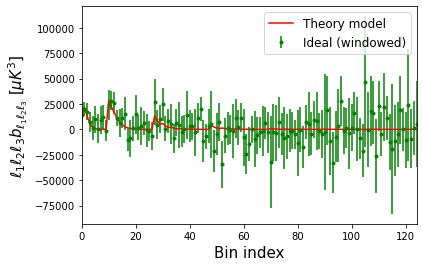

In [12]:
weights = []
bl_model = []
for bin1 in range(Nl):
    for bin2 in range(bin1,Nl):
        for bin3 in range(bin2,Nl):
            # skip bins outside the triangle conditions
            if not bspec._check_bin(bin1,bin2,bin3): continue
            weights.append((min_l+(bin1+0.5)*dl)*(min_l+(bin2+0.5)*dl)*(min_l+(bin3+0.5)*dl)*1e18)
            bl_model.append(b_input_fac(min_l+(bin1+0.5)*dl)*b_input_fac(min_l+(bin2+0.5)*dl)*b_input_fac(min_l+(bin3+0.5)*dl))
weights = np.asarray(weights)
bl_model = np.asarray(bl_model)
            
fish_err_ideal = np.sqrt(np.diag(bspec.inv_fish_ideal))*np.mean(mask**6)/np.mean(mask**3)**2

plt.errorbar(np.arange(bspec.N_b),weights*b_ideal,yerr=weights*fish_err_ideal,marker='.',ls='',label='Ideal (windowed)',c='g')
plt.plot(np.arange(bspec.N_b),weights*bl_model,label='Theory model',c='r')
plt.xlim([0,bspec.N_b-1])
plt.xlabel(r'Bin index',fontsize=15)
plt.ylabel(r'$\ell_1\ell_2\ell_3b_{\ell_1\ell_2\ell_3}\,\,[\mu K^3]$',fontsize=15)
plt.legend(fontsize=12)

### Window-free estimator

In [13]:
# Generate MC simulations for estimator numerator
bspec.generate_sims(N_it,b_input=b_input_fac,add_B=True,remove_mean=True)

# # Alternatively, read-in MC simulations created externally
# alpha_sims = []
# for ii in range(N_it):
#     alpha = base.generate_data(seed=10000+ii,add_B=include_synthetic_b, b_input=b_input_fac)
#     alpha_sims.append(alpha)
# bspec.load_sims(alpha_sims, verb=True)

Using 20 Monte Carlo simulations
Computing offset for synthetic maps


In [14]:
fish = bspec.compute_fisher(N_it, N_cpus=4)

Computing Fisher contribution from 20 pairs of Monte Carlo simulations on 4 threads


100%|██████████| 20/20 [19:55<00:00, 59.76s/it]  


In [15]:
b_unwindowed = bspec.Bl_unwindowed(data, verb=True, include_linear_term=True)

Computing b_3 piece
Computing b_1 piece from simulation 5
Computing b_1 piece from simulation 10
Computing b_1 piece from simulation 15
Computing b_1 piece from simulation 20


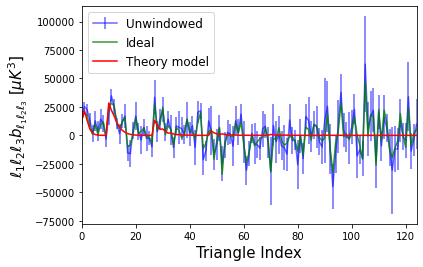

In [16]:
fish_err = np.sqrt(np.diag(np.linalg.inv(bspec.fish)))
plt.errorbar(np.arange(bspec.N_b),weights*b_unwindowed,yerr=weights*fish_err,label='Unwindowed',c='b',alpha=0.6)
plt.errorbar(np.arange(bspec.N_b),weights*b_ideal,label='Ideal',c='g',alpha=0.8)
if include_synthetic_b:
    plt.errorbar(np.arange(bspec.N_b),weights*bl_model,label='Theory model',c='r')
else:
    plt.errorbar(np.arange(bspec.N_b),0.*weights*bl_model,label='Theory model',c='r')
plt.legend(fontsize=12)
plt.xlim([0,bspec.N_b-1])
plt.xlabel("Triangle Index",fontsize=15)
plt.ylabel(r"$\ell_1\ell_2\ell_3 b_{\ell_1\ell_2\ell_3}\,\,[\mu K^3]$",fontsize=15);

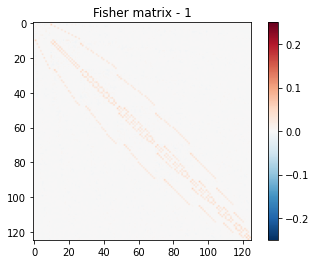

In [17]:
corr_fish_b = bspec.fish/np.sqrt(np.outer(np.diag(bspec.fish),np.diag(bspec.fish)))
v = 0.25
plt.imshow(corr_fish_b-np.eye(len(corr_fish_b)),cmap=cm.RdBu_r,vmax=v,vmin=-v)
plt.title("Fisher matrix - 1")
plt.colorbar();

### Iterate over multiple datasets

In [18]:
b_unwindowed_all = []
b_ideal_all = []

for jj in range(N_sim):
    
    if jj%10==0: 
        print("Analyzing simulation %d of %d"%(jj+1,N_sim))

    # Generate unmasked data
    data = mask*base.generate_data(jj,add_B=include_synthetic_b, b_input=b_input_fac)

    b_ideal_all.append(bspec.Bl_ideal(data))
    b_unwindowed_all.append(bspec.Bl_unwindowed(data,verb=False))

Analyzing simulation 1 of 50
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Analyzing simulation 11 of 50
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Analyzing simulation 21 of 50
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomput

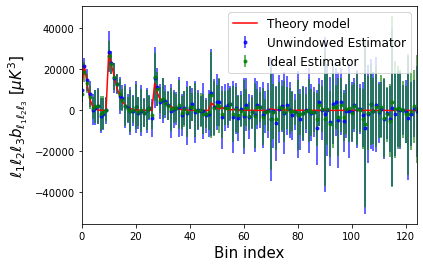

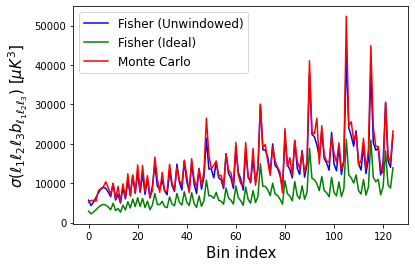

In [19]:
fish_err = np.sqrt(np.diag(bspec.inv_fish))
fish_err_ideal = np.sqrt(np.diag(bspec.inv_fish_ideal))

plt.errorbar(np.arange(bspec.N_b),weights*np.asarray(b_unwindowed_all).mean(axis=0),yerr=weights*fish_err,marker='.',ls='',label='Unwindowed Estimator',c='b',alpha=0.8)
plt.plot(np.arange(bspec.N_b),weights*bl_model,label='Theory model',c='r')
plt.errorbar(np.arange(bspec.N_b),weights*np.asarray(b_ideal_all).mean(axis=0),yerr=weights*np.asarray(b_ideal_all).std(axis=0),
             ls='',marker='.',label='Ideal Estimator',alpha=0.8,c='g')
plt.xlim([0,bspec.N_b-1])
plt.xlabel(r'Bin index',fontsize=15)
plt.ylabel(r'$\ell_1\ell_2\ell_3b_{\ell_1\ell_2\ell_3}\,\,[\mu K^3]$',fontsize=15)
plt.legend(fontsize=12)

plt.figure()
plt.plot(np.arange(bspec.N_b),weights*fish_err,label='Fisher (Unwindowed)',c='b')
plt.plot(np.arange(bspec.N_b),weights*fish_err_ideal,label=r'Fisher (Ideal)',c='g')
plt.plot(np.arange(bspec.N_b),weights*np.asarray(b_unwindowed_all).std(axis=0),label='Monte Carlo',c='r')
plt.xlabel(r'Bin index',fontsize=15)
plt.legend(fontsize=12)
plt.ylabel(r'$\sigma(\ell_1\ell_2\ell_3b_{\ell_1\ell_2\ell_3})\,\,[\mu K^3]$',fontsize=15);

# Trispectrum Estimation

We now consider the trispectrum. Since trispectrum estimation is considerably more expensive, we'll use a broader binning here. In general, calculations would be performed on a cluster, but we'll pick a small problem below for testing on a single computer.

In [1]:
%pylab inline
import healpy
import polybin as pb
from scipy.interpolate import InterpolatedUnivariateSpline

# HEALPix settings
Nside = 128
lmax = 3*Nside-1

# Binning parameters
dl = 30 # width
Nl = 10 # number
min_l = 2 # minimum
print("binned lmax: %d"%(min_l+dl*Nl))

# Number of random iterations to create Fisher matrix
N_it = 20

# Number of simulations to use for testing
N_sim = 50

# Whether to include bins only partially satisfying triangle conditions
include_partial_triangles = False

# whether to add a separable reduced bispectrum to the input maps
include_synthetic_b = True
b_input_fac = lambda l1: np.exp(-(l1-2)/40.)*2e-6

# Galactic Mask
# Using GAL040 mask with 2-degree apodization for testing
root = '/projects/QUIJOTE/Oliver/planck/'
maskfile = 'HFI_Mask_GalPlane-apo2_2048_R2.00.fits'

from classy import Class
cosmo = Class()

# Define ell arrays
l = np.arange(lmax+1)

# Run CLASS
cosmo.set({'output':'tCl,lCl,mPk','l_max_scalars':lmax+1,'lensing':'yes',
           'omega_b':0.022383,
           'non linear':'no',
           'omega_cdm':0.12011,
           'h':0.6732,
           'm_ncdm':0.06,
           'N_ncdm':1,
           'tau_reio':0.0543,
           'A_s':1e-10*np.exp(3.0448),
           'n_s':0.96605});
cosmo.compute()

# Compute signal C_ell
Cl_dict = cosmo.lensed_cl(lmax);
Cl_th = Cl_dict['tt']*cosmo.T_cmb()**2

# Compute noise C_ell
DeltaT = 60./60.*np.pi/180.*1e-6 # in K-radians
thetaFWHM = 5./60.*np.pi/180. # in radians
Nl_th = DeltaT**2*np.exp(l*(l+1)*thetaFWHM**2/(8.*np.log(2)))*(l>2)

mask = healpy.ud_grade(healpy.read_map(root+maskfile,field=1),Nside)

# print("REMOVING MASK")
# mask = np.ones_like(mask)

# Load class
base = pb.PolyBin(Nside,Cl_th+Nl_th)

# Generate unmasked data with known C_l and factorized b
# Cl is set to the fiducial spectrum unless otherwise specified
# No beam is included
raw_data = base.generate_data(seed=42, add_B=include_synthetic_b, b_input=b_input_fac)

# Mask the map
data = raw_data*mask

def applySinv(input_map):
    """Apply the optimal weighting to a map. 
    
    Here, we assume that the forward covariance is diagonal, in particular C_l, and invert this.
    This is not quite the exact solution (as it incorrectly treats W(n) factors), but should be unbiased."""
    
    # Transform to harmonic space
    input_map_lm = base.to_lm(input_map)
    # Divide by covariance and return to map-space
    Cinv_map = base.to_map(base.safe_divide(input_map_lm,base.Cl_lm))
    
    return Cinv_map

Populating the interactive namespace from numpy and matplotlib
binned lmax: 302
Computing offset for synthetic maps


In [2]:
# Initialize trispectrum class
min_l = 10
dl = 20
Nl = 4
tspec = pb.TSpec(base, mask, applySinv, min_l, dl, Nl)

Binning: 4 bins in [10, 90]


In [3]:
fish_odd = tspec.compute_fisher(1,parity='odd',N_cpus=1,verb=True)

Using 121 odd-parity trispectrum bins
Computing Fisher contribution 1 of 1

Generating data

Creating H maps for S-inverse-weighted fields
Computing A[u1,u2] maps for S-inverse-weighted fields
Computing raw Q maps for S-inverse-weighted fields
Assembling Q filters for S-inverse-weighted fields

Creating H maps for U-inverse-weighted fields
Computing A[u1,u2] maps for U-inverse-weighted fields
Computing raw Q maps for U-inverse-weighted fields
Assembling Q filters for U-inverse-weighted fields

Computing Fisher matrix contribution
On bin 1 of 121
On bin 6 of 121
On bin 11 of 121
On bin 16 of 121
On bin 21 of 121
On bin 26 of 121
On bin 31 of 121
On bin 36 of 121
On bin 41 of 121
On bin 46 of 121
On bin 51 of 121
On bin 56 of 121
On bin 61 of 121
On bin 66 of 121
On bin 71 of 121
On bin 76 of 121
On bin 81 of 121
On bin 86 of 121
On bin 91 of 121
On bin 96 of 121
On bin 101 of 121
On bin 106 of 121
On bin 111 of 121
On bin 116 of 121
On bin 121 of 121


In [4]:
tspec.generate_sims(10)

Using 10 Monte Carlo simulations


In [5]:
t_odd = tspec.Tl_unwindowed(data,parity='odd',verb=True)

Computing t0 term
Computing H^+- maps
Computing A maps
Computing A maps for cross-spectra
Assembling parity-odd trispectrum numerator


In [6]:
fish_both = tspec.compute_fisher(1,parity='both',N_cpus=1,verb=True)

Using 154 even-parity trispectrum bins
Computing Fisher contribution 1 of 1

Generating data

Creating H maps for S-inverse-weighted fields
Computing A[u1,u2] maps for S-inverse-weighted fields
Computing raw Q maps for S-inverse-weighted fields
Assembling Q filters for S-inverse-weighted fields

Creating H maps for U-inverse-weighted fields
Computing A[u1,u2] maps for U-inverse-weighted fields
Computing raw Q maps for U-inverse-weighted fields
Assembling Q filters for U-inverse-weighted fields

Computing Fisher matrix contribution
On bin 1 of 154
On bin 6 of 154
On bin 11 of 154
On bin 16 of 154
On bin 21 of 154
On bin 26 of 154
On bin 31 of 154
On bin 36 of 154
On bin 41 of 154
On bin 46 of 154
On bin 51 of 154
On bin 56 of 154
On bin 61 of 154
On bin 66 of 154
On bin 71 of 154
On bin 76 of 154
On bin 81 of 154
On bin 86 of 154
On bin 91 of 154
On bin 96 of 154
On bin 101 of 154
On bin 106 of 154
On bin 111 of 154
On bin 116 of 154
On bin 121 of 154
On bin 126 of 154
On bin 131 of 154

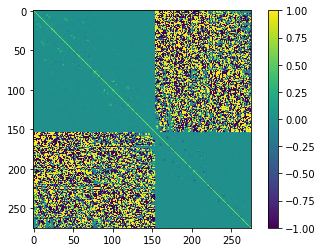

In [10]:
ff = fish_both
corr_fish = ff/np.sqrt(np.outer(np.diag(ff),np.diag(ff)))
plt.imshow(corr_fish,vmax=1,vmin=-1);
plt.colorbar();

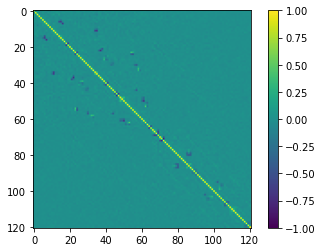

In [7]:
ff = fish_odd
corr_fish = ff/np.sqrt(np.outer(np.diag(ff),np.diag(ff)))
plt.imshow(corr_fish,vmax=1,vmin=-1);
plt.colorbar();

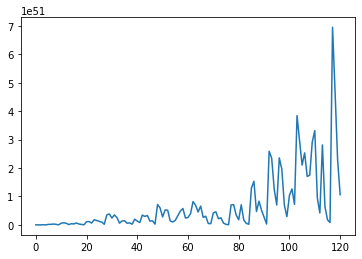

In [8]:
plt.plot(np.diag(fish_odd))

<ErrorbarContainer object of 3 artists>

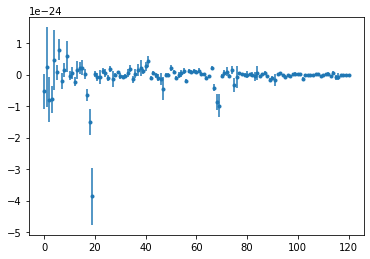

In [9]:
plt.errorbar(np.arange(tspec.N_t_odd),t_odd,yerr=np.sqrt(np.diag(tspec.inv_fish_odd)),ls='',marker='.')

### no mask here!

### a) window is weird??

### b) off-diagonal is weird - should asymptote to zero?

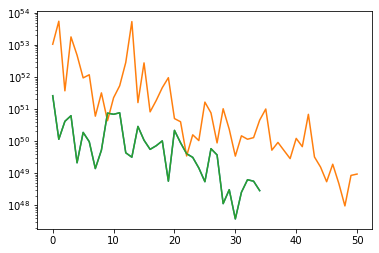

In [20]:
plt.plot(np.abs(np.diag(fish_both)[tspec.N_t_even:]))
plt.plot(np.diag(fish_even))
plt.plot(-np.diag(fish_odd))
plt.yscale('log')

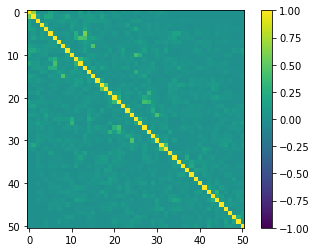

In [40]:
ff = np.abs(fish_even)
corr_fish = ff/np.sqrt(np.outer(np.diag(ff),np.diag(ff)))
plt.imshow(corr_fish,vmax=1,vmin=-1);
plt.colorbar();

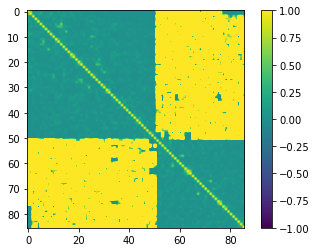

In [43]:
ff = np.abs(fish_both)
corr_fish = ff/np.sqrt(np.outer(np.diag(ff),np.diag(ff)))
plt.imshow(corr_fish,vmax=1,vmin=-1);
plt.colorbar();

In [47]:
tspec.generate_sims(10,Cl_th+Nl_th)

Using 10 Monte Carlo simulations


In [48]:
t_unwindowed_even = tspec.Tl_numerator(data,parity='both',verb=True)

Computing t0 term
Computing t0 term
Computing H^+- maps
Computing A maps
Computing A maps for cross-spectra
Assembling parity-even trispectrum numerator
Assembling parity-odd trispectrum numerator


### cross-terms don't seem to work yet??
### check there's the same symmetry there!

### could check just with a constant window that there's no effects?

## can we use transpose symmetry to drop half the Fisher matrix bins? force index2>index1?

## switch to just computing Im part of trispectrum?
## also helps in Fisher?

In [3]:
t_even, t_odd = tspec.Tl_ideal(data,parity='both',verb=True)

Computing ideal Fisher matrix
Using 51 even-parity trispectrum bins
Using 35 odd-parity trispectrum bins
Computing bin 5 of 51
Computing bin 10 of 51
Computing bin 15 of 51
Computing bin 20 of 51
Computing bin 25 of 51
Computing bin 30 of 51
Computing bin 35 of 51
Computing bin 40 of 51
Computing bin 45 of 51
Computing bin 50 of 51
Computing numerator
Computing H^+- maps
Computing A maps
Assembling parity-even trispectrum numerator
Assembling parity-odd trispectrum numerator


In [4]:
t_even2 = tspec.Tl_ideal(data,parity='even',verb=True)

Using precomputed Fisher matrix
Computing numerator
Computing H^+- maps
Computing A maps
Assembling parity-even trispectrum numerator
